In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.svm import SVC, LinearSVC
from tensorflow import keras
from functools import partial
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
%matplotlib inline
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.constrained_layout.use'] = True

In [2]:
url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/san-andreas/earthquake_data.csv'
data = pd.read_csv(url, index_col = 0)

In [3]:
data

,"How worried are you about the Big One, a massive, catastrophic earthquake?","Do you think the ""Big One"" will occur in your lifetime?",Have you ever experienced an earthquake?,"Have you or anyone in your household taken any precautions for an earthquake (packed an earthquake survival kit, prepared an evacuation plan, etc.)?",How familiar are you with the San Andreas Fault line?,How familiar are you with the Yellowstone Supervolcano?,Age,What is your gender?,How much total combined money did all members of your HOUSEHOLD earn last year?,US Region
"In general, how worried are you about earthquakes?",,,,,,,,,,
Not at all worried,Not so worried,No,"Yes, one or more minor ones",No,Somewhat familiar,Not so familiar,18 - 29,Male,Prefer not to answer,New England
Somewhat worried,Very worried,No,"Yes, one or more minor ones",No,Not at all familiar,Not at all familiar,18 - 29,Male,"$75,000 to $99,999",East North Central
Not so worried,Somewhat worried,No,"Yes, one or more minor ones",No,Very familiar,Somewhat familiar,18 - 29,Male,"$10,000 to $24,999",Pacific
Not so worried,Not so worried,No,"Yes, one or more minor ones",No,Very familiar,Not so familiar,18 - 29,Male,"$25,000 to $49,999",West South Central
Not so worried,Not so worried,Yes,"Yes, one or more minor ones",No,Somewhat familiar,Extremely familiar,18 - 29,Male,"$200,000 and up",Middle Atlantic
...,...,...,...,...,...,...,...,...,...,...
Not at all worried,Not at all worried,No,"Yes, one or more minor ones",No,Very familiar,Not so familiar,60,Male,Prefer not to answer,Pacific
Not so worried,Somewhat worried,No,"Yes, one or more major ones",Yes,Extremely familiar,Somewhat familiar,60,Female,"$50,000 to $74,999",Pacific
Not so worried,Extremely worried,No,"Yes, one or more minor ones",No,Somewhat familiar,Somewhat familiar,30 - 44,Female,Prefer not to answer,Middle Atlantic


In [4]:
data.isnull().sum()

How worried are you about the Big One, a massive, catastrophic earthquake?                                                                               0
Do you think the "Big One" will occur in your lifetime?                                                                                                  0
Have you ever experienced an earthquake?                                                                                                                 7
Have you or anyone in your household taken any precautions for an earthquake (packed an earthquake survival kit, prepared an evacuation plan, etc.)?     7
How familiar are you with the San Andreas Fault line?                                                                                                   12
How familiar are you with the Yellowstone Supervolcano?                                                                                                 12
Age                                                                   

Let's drop null rows

In [5]:
#Cleaning Data
data.dropna(inplace = True)
data.isnull().sum()

How worried are you about the Big One, a massive, catastrophic earthquake?                                                                              0
Do you think the "Big One" will occur in your lifetime?                                                                                                 0
Have you ever experienced an earthquake?                                                                                                                0
Have you or anyone in your household taken any precautions for an earthquake (packed an earthquake survival kit, prepared an evacuation plan, etc.)?    0
How familiar are you with the San Andreas Fault line?                                                                                                   0
How familiar are you with the Yellowstone Supervolcano?                                                                                                 0
Age                                                                         

Now we need to encode every column. First we need to check if there is a scale order to the answer.

In [6]:
for col in data.columns:
    print( data[col].unique())

['Not so worried' 'Very worried' 'Somewhat worried' 'Not at all worried'
 'Extremely worried']
['No' 'Yes']
['Yes, one or more minor ones' 'No' 'Yes, one or more major ones']
['No' 'Yes']
['Somewhat familiar' 'Not at all familiar' 'Very familiar'
 'Not so familiar' 'Extremely familiar']
['Not so familiar' 'Not at all familiar' 'Somewhat familiar'
 'Extremely familiar' 'Very familiar']
['18 - 29' '30 - 44' '45 - 59' '60']
['Male' 'Female']
['Prefer not to answer' '$75,000 to $99,999' '$10,000 to $24,999'
 '$25,000 to $49,999' '$200,000 and up' '$50,000 to $74,999'
 '$0 to $9,999' '$100,000 to $124,999' '$175,000 to $199,999'
 '$125,000 to $149,999' '$150,000 to $174,999']
['New England' 'East North Central' 'Pacific' 'West South Central'
 'Middle Atlantic' 'South Atlantic' 'West North Central'
 'East South Central' 'Mountain']


In [7]:
data_encoded = data
data_encoder = OrdinalEncoder()
data_encoded.iloc[:,[1,2,3,6,7,8,9]] = data_encoder.fit_transform(data.iloc[:,[1,2,3,6,7,8,9]])

#Ordered index for some columnns to maintain a logical scale
map1 = {'Not at all worried':0, 'Not so worried':1, 'Somewhat worried':2, 'Very worried':3, 'Extremely worried':4}
map2 = {'Not at all familiar':0, 'Not so familiar':1, 'Somewhat familiar':2, 'Very familiar':3, 'Extremely familiar':4}

data_encoded.iloc[:,0] = data.iloc[:,0].map(map1)
data_encoded.iloc[:,4] = data.iloc[:,4].map(map2)
data_encoded.iloc[:,5] = data.iloc[:,5].map(map2)

data_encoded.index = data_encoded.index.map(map1)
data_encoded.columns = ['big one', 'big one occurence','experienced hq', 'precautions', 'sa familiarity', 'ys familiarity', 'age', 'gender', 'income', 'region']
data_encoded.index.name = 'worry scale'
data_encoded

,big one,big one occurence,experienced hq,precautions,sa familiarity,ys familiarity,age,gender,income,region
worry scale,,,,,,,,,,
0,1,0.0,2.0,0.0,2,1,0.0,1.0,10.0,4.0
2,3,0.0,2.0,0.0,0,0,0.0,1.0,9.0,0.0
1,2,0.0,2.0,0.0,3,2,0.0,1.0,1.0,5.0
1,1,0.0,2.0,0.0,3,1,0.0,1.0,7.0,8.0
1,1,1.0,2.0,0.0,2,4,0.0,1.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...
0,0,0.0,0.0,0.0,2,2,3.0,0.0,10.0,4.0
0,0,0.0,2.0,0.0,3,1,3.0,1.0,10.0,5.0
1,2,0.0,1.0,1.0,4,2,3.0,0.0,8.0,5.0


<AxesSubplot:>

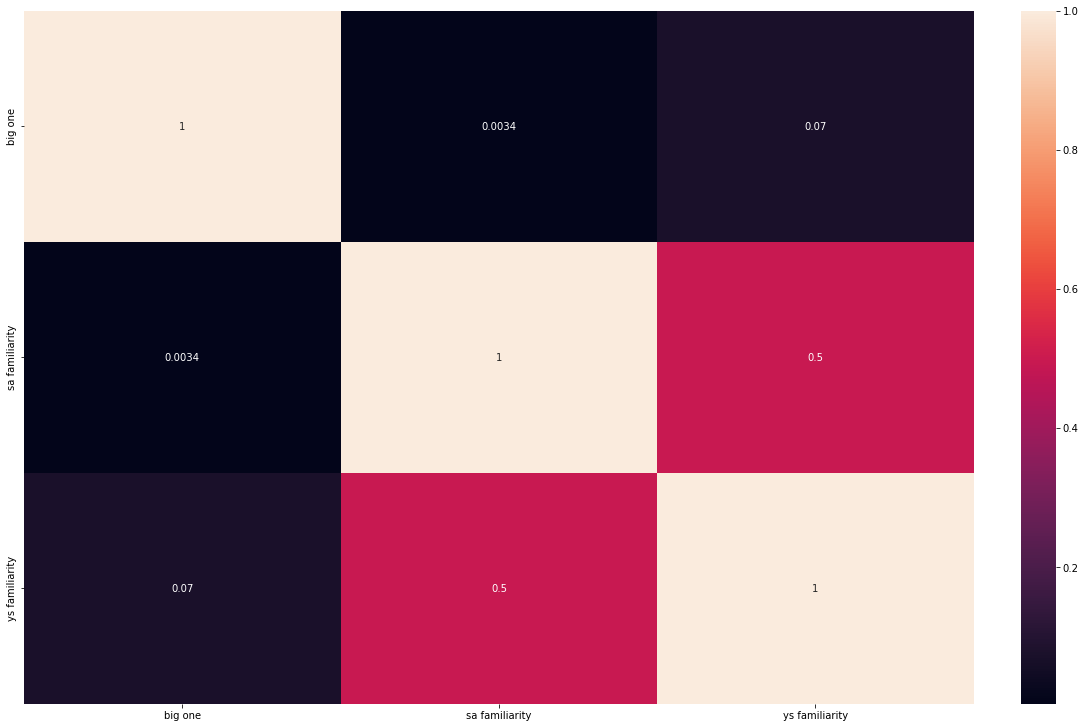

In [8]:
corr = data_encoded.corr()
sns.heatmap(corr, annot = True)

Let's split data and train the algorithms, considerations will be taken at the end of training and predictions of every model.
<br>
Let's train a beseline models

In [9]:
xtrain, xtest, ytrain, ytest = train_test_split(data_encoded.values, data_encoded.index)
scaler = StandardScaler()

rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

rf.fit(xtrain, ytrain)
gb.fit(xtrain, ytrain)

print(f'Random forest: train score {rf.score(xtrain,ytrain)}, test score {rf.score(xtest, ytest)}')
print(f'Gradient boosting: train score {gb.score(xtrain,ytrain)}, test score {gb.score(xtest, ytest)}')

Random forest: train score 0.9959072305593452, test score 0.6775510204081633
Gradient boosting: train score 0.8867667121418826, test score 0.7020408163265306


Both models are overfitting, let's tune the hyperparameters

0.903137789904502 0.6998322616717919 0.6979591836734694
{'max_depth': 8, 'n_estimators': 90}


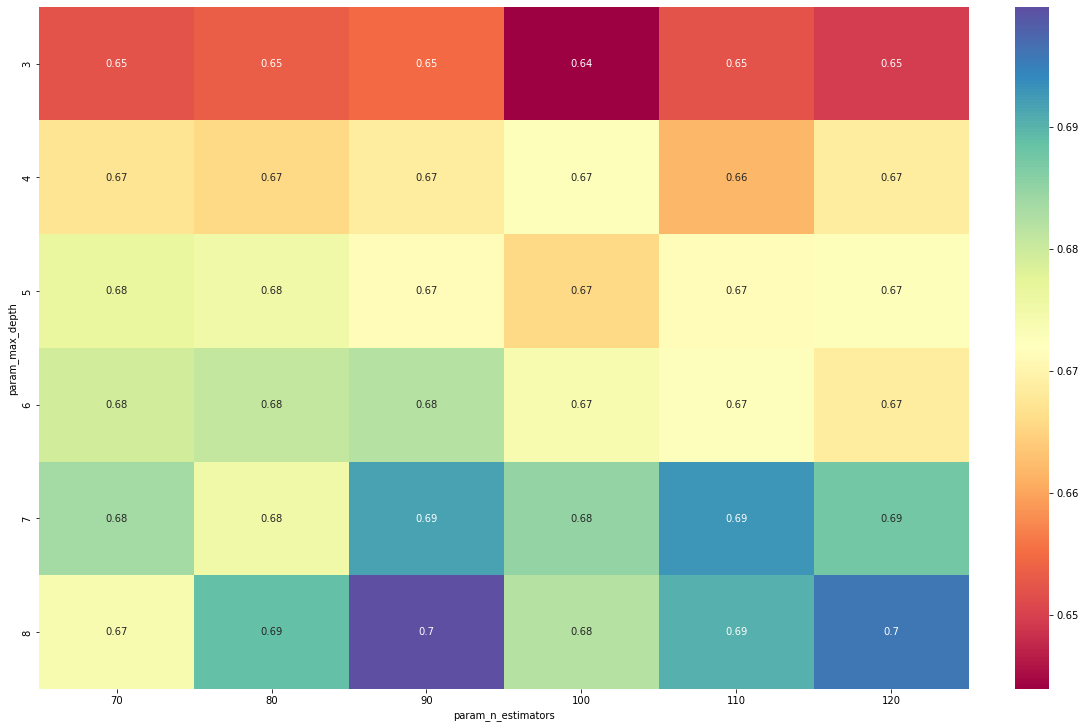

In [10]:
#Random forest Classifier
parameters = {'max_depth':[d for d in range(3,9)], 'n_estimators':[i*10 for i in range(7,13)]}

rf = RandomForestClassifier()
grid = GridSearchCV(rf, parameters) 
grid.fit(xtrain, ytrain)
bestforest = grid.best_estimator_

hmRF = pd.pivot_table(pd.DataFrame(grid.cv_results_),
									values='mean_test_score',
									index='param_max_depth',
									columns='param_n_estimators')

sns.heatmap(hmRF, cmap = 'Spectral', annot = True)                                        
print(bestforest.score(xtrain, ytrain), grid.best_score_, bestforest.score(xtest, ytest))
print(grid.best_params_)

<AxesSubplot:>

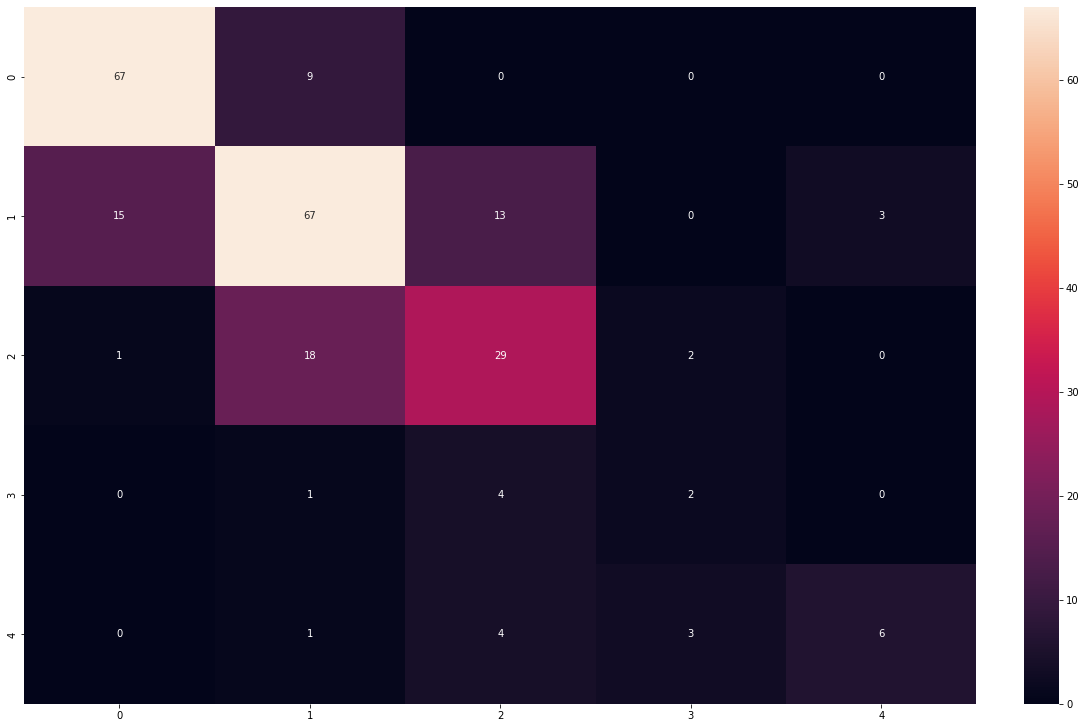

In [11]:
cm_rf = confusion_matrix(ytest, grid.predict(xtest))
sns.heatmap(cm_rf, annot=True)

0.7394270122783083 0.710772528189358 0.7510204081632653
{'learning_rate': 0.2, 'max_depth': 1}


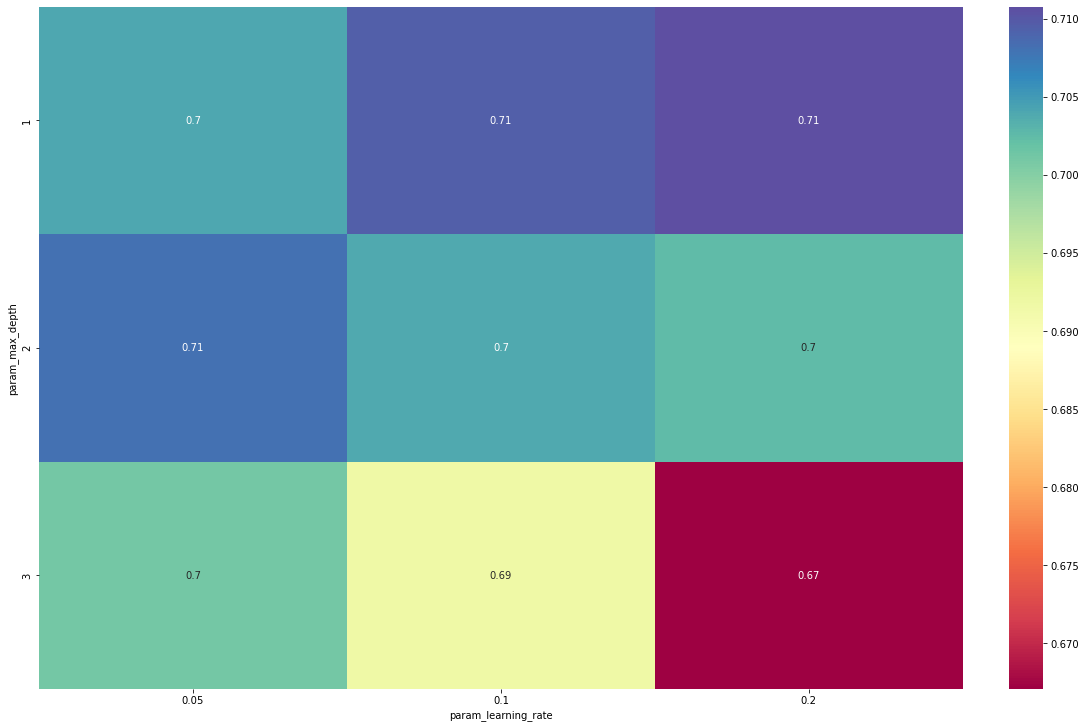

In [12]:
#Gradient Boosting Classifier
params = {'learning_rate':[0.05, 0.1, 0.2], 'max_depth':[1,2,3]}

gb = GradientBoostingClassifier(max_features = 'sqrt')
grid = GridSearchCV(gb, params)
grid.fit(xtrain, ytrain)
best = grid.best_estimator_
    
#Plot griglia di parametri
hmGB = pd.pivot_table(pd.DataFrame(grid.cv_results_),
									values='mean_test_score',
									index='param_max_depth',
									columns='param_learning_rate')
sns.heatmap(hmGB, cmap = 'Spectral', annot = True)

print(best.score(xtrain, ytrain), grid.best_score_, best.score(xtest, ytest))
print(grid.best_params_)

<AxesSubplot:>

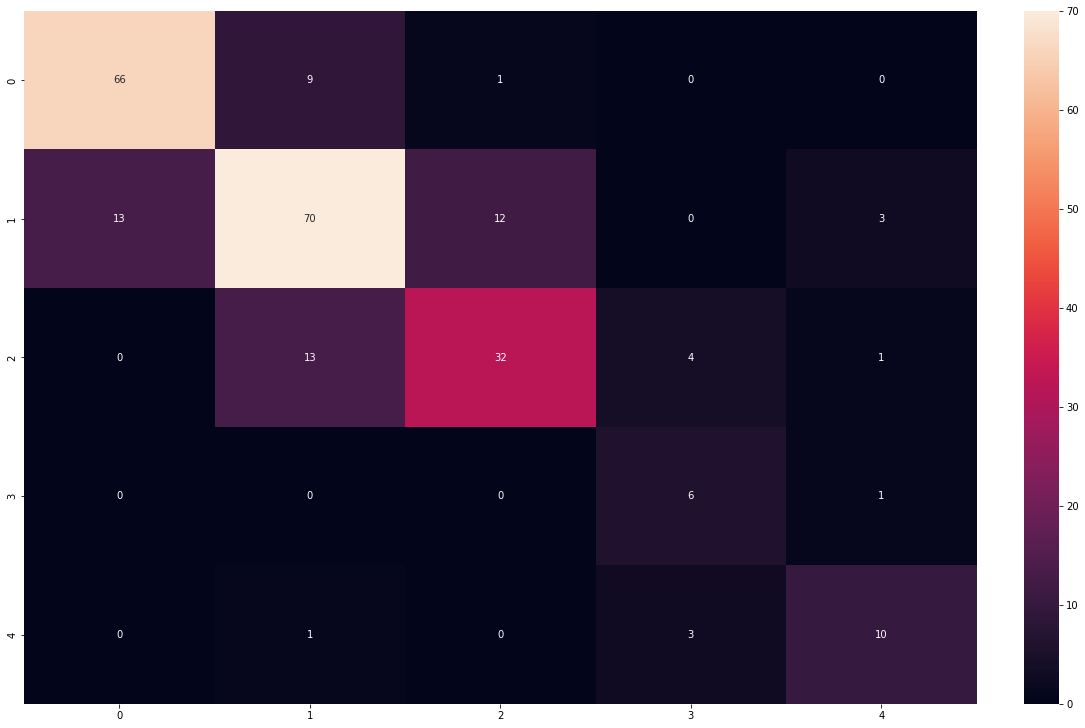

In [13]:
cm_gb = confusion_matrix(ytest, grid.predict(xtest))
sns.heatmap(cm_gb, annot=True)

In [14]:
#Neural Network
RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           #kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.015)
                          )

callback = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)
kf = StratifiedKFold(n_splits = 3)
tra, val = [], []

for train, valid in kf.split(xtrain, ytrain):
#Scaling data
    xtrain_scaled = scaler.fit_transform(xtrain[train])
    xvalid_scaled = scaler.transform(xtrain[valid])
                
    #Neural Network
    neural = keras.models.Sequential([
        keras.layers.InputLayer(input_shape = data_encoded.shape[1]),
        RegularizedDense(1500),
        RegularizedDense(2500),
        RegularizedDense(100),
        keras.layers.Dense(len(np.unique(data_encoded.index)), activation = 'softmax')])

    neural.compile( loss = 'sparse_categorical_crossentropy', optimizer = 'Nadam', metrics = ['accuracy'])
    history = neural.fit(xtrain_scaled, ytrain[train],
                        validation_data = (xvalid_scaled, ytrain[valid]),
                        epochs = 70,
                        callbacks = [callback], verbose = 0)
    
    tra.append(max(list(history.history['accuracy'])))
    val.append(max(list(history.history['val_accuracy'])))

score = pd.DataFrame({'mean_train_score':np.mean(tra), 'mean_valid_score':np.mean(val)}, [0])

xtest_scaled = scaler.transform(xtest)
score['test_score'] = neural.evaluate(xtest_scaled, ytest)[1]
score

8/8 [==============================] - 0s 5ms/step - loss: 1.1467 - accuracy: 0.5837


,mean_train_score,mean_valid_score,test_score
0,0.693719,0.706658,0.583673


8/8 [==============================] - 0s 5ms/step


Text(-0.999760000000002, 0.5, 'Predicted')

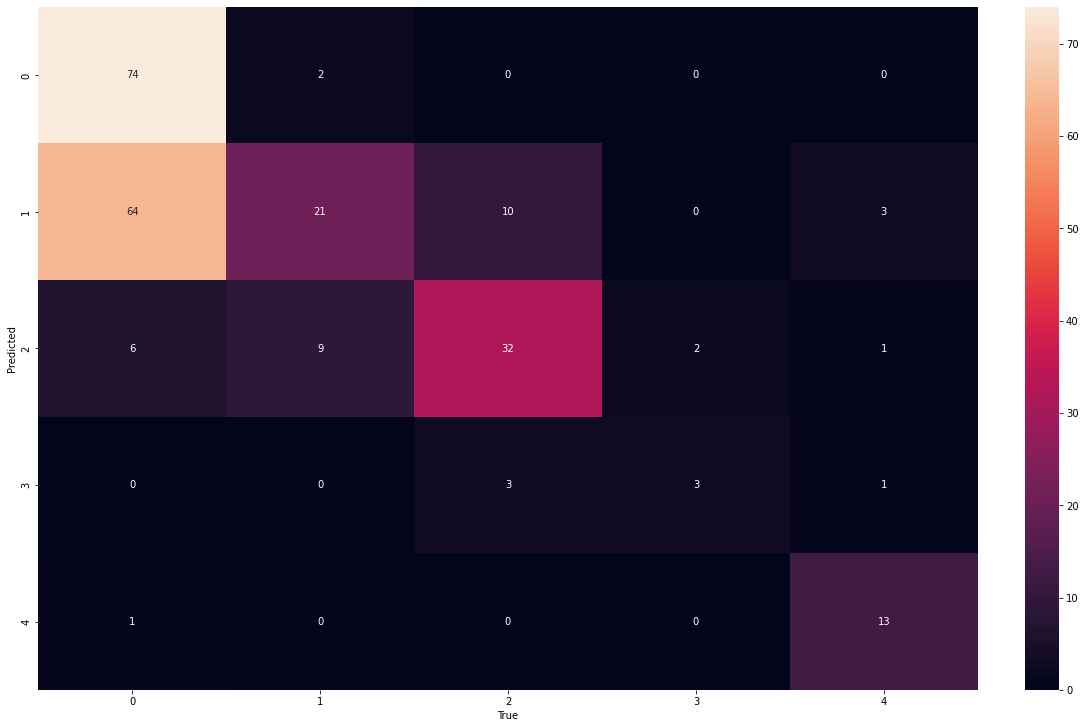

In [15]:
mlp_predictions = np.argmax(neural.predict(xtest_scaled), axis = 1)
mlp_cm = confusion_matrix(ytest, mlp_predictions)
sns.heatmap(mlp_cm, annot=True)
plt.xlabel('True')
plt.ylabel('Predicted')

Even with hyperparameters tuning, the accuracy of the models didn't increase, but we reduced overfitting.
<br>
Conclusions:
<br>
As we can see from the previous algorithms we can estimante with around 70% people's worry degree about an earthquake. 
<br>
The algorithms used performs in a similar way, but gradient boosting overfit less, so this would be the best pick.
<br> 
Observing the confusion matrices one can say that even when algorithms missmatch, the prevsion is near the correct answer, in fact we can see the form of a tridiagonal matrix.